# Analysis

**Hypothesis**: The tutoring program’s effect on academic performance evolves over time—initial gains may be strong shortly after intervention and then taper off—indicating dynamic treatment effects that an event study design can reveal.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Econometrics libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
try:
    from linearmodels.panel import PanelOLS
except Exception:
    PanelOLS = None

# Visualization defaults
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
warnings.filterwarnings('ignore')

# Load data
print('Loading data...')
df = pd.read_stata('aea_packages/228584_V1/Data_analysis/Data/TOP1_TOP3_Dataset.dta')
print(f"Data loaded: {df.shape[0]} rows and {df.shape[1]} columns")
print('Columns:', list(df.columns)[:20])


Loading data...
Data loaded: 2196 rows and 261 columns
Columns: ['Group_Tutoring', 'ID_student', 'ID_tutor', 'ID_tutor_3', 'SES_5', 'TOP1', 'TOP3', 'always_f_online_classes_pe_1', 'always_f_online_classes_se_1', 'aspirations', 'aspirations_uni_pe', 'aspirations_uni_se', 'aspirations_uni_te', 'barrier_money_sb', 'barrier_parents_sb', 'barrier_self_sb', 'choice_prof_se', 'choose_topliceo_se', 'choose_vocational_se', 'comp_skills_tub']


# Analysis Plan

**Hypothesis**: The tutoring program’s effect on academic performance evolves over time—initial gains may be strong shortly after intervention and then taper off—indicating dynamic treatment effects that an event study design can reveal.

## Steps:
- Perform an exploratory data analysis (EDA) to assess the distribution of the time variable (days_delta) and the academic outcome (grade_mat_admin_endline) by treatment status, including visualization overlays by treatment and an explicit check on missing values in these variables.
- Estimate a baseline OLS regression of the academic outcome on the treatment indicator (treat) while controlling for key covariates to replicate the average treatment effect.
- Construct an event study framework by creating time bins or lead/lag indicators from the days_delta variable to capture the dynamic treatment effects over time.
- Estimate the event study regression that interacts time indicators with treatment while controlling for covariates and fixed effects, ensuring standard errors are robust or clustered.
- Visualize the event study coefficients with confidence intervals to illustrate the treatment effect dynamics and perform robustness checks by varying bin widths or including additional controls.


## This code performs an initial exploratory analysis by checking for missing data in key variables and visualizing the distribution of days_delta with treatment group overlays. It also provides descriptive statistics for the academic outcome variable by treatment status to assess data quality and group differences.

days_delta: 1694 missing out of 2196 ( 77.1% missing)
grade_mat_admin_endline: 17 missing out of 2196 ( 0.8% missing)
treat: 0 missing out of 2196 ( 0.0% missing)


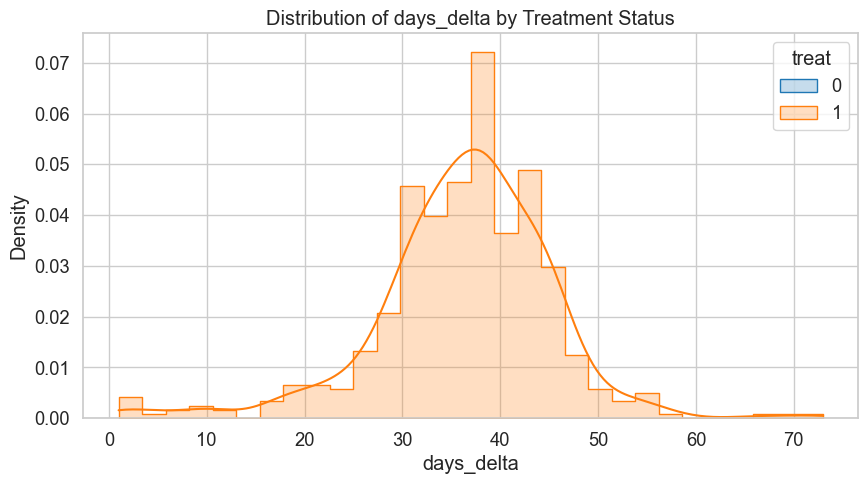

Summary Statistics for grade_mat_admin_endline (Treatment Group):
count    1128.000000
mean        6.236702
std         1.025756
min         4.000000
25%         6.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: grade_mat_admin_endline, dtype: float64

Summary Statistics for grade_mat_admin_endline (Control Group):
count    1051.000000
mean        6.171266
std         1.086354
min         4.000000
25%         6.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: grade_mat_admin_endline, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is the pre-loaded DataFrame

# Check missing values for key variables
key_vars = ['days_delta', 'grade_mat_admin_endline', 'treat']
for var in key_vars:
    missing_count = df[var].isna().sum()
    total = len(df[var])
    print(f"{var}: {missing_count} missing out of {total} ( {missing_count/total:.1%} missing)")

# Plot distribution of 'days_delta' with a hue to differentiate treatment groups
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='days_delta', hue='treat', bins=30, kde=True, element='step', stat='density')
plt.title('Distribution of days_delta by Treatment Status')
plt.xlabel('days_delta')
plt.ylabel('Density')
plt.show()

# Summary statistics for academic outcome (grade_mat_admin_endline) by treatment
outcome = 'grade_mat_admin_endline'
summary_treatment = df[df['treat'] == 1][outcome].describe()
summary_control = df[df['treat'] == 0][outcome].describe()

print('Summary Statistics for grade_mat_admin_endline (Treatment Group):')
print(summary_treatment)
print('\nSummary Statistics for grade_mat_admin_endline (Control Group):')
print(summary_control)

### Agent Interpretation

The first step in your analysis primarily identifies issues with missing data, especially with the `days_delta` variable, which has 77.1% missing values. This significant level of missing data is critical because it may affect the analysis of dynamic treatment effects over time, which relies heavily on this variable.

### Feedback:

1. **Conduct Missing Data Analysis:**
   - Explore the patterns and potential reasons for the missing data in `days_delta`. Analyze whether the missingness is related to the treatment or outcome variables, which might introduce bias.

2. **Imputation or Data Collection:**
   - Consider imputation strategies (e.g., multiple imputation) if suitable, or revisit data collection efforts to retrieve missing data if it's feasible and ethical. 

3. **Summary Statistics:**
   - The summary statistics for `grade_mat_admin_endline` indicate similar mean scores between the treatment and control groups, suggesting limited immediate differences. However, these are raw averages and should be interpreted cautiously without covariate controls.

4. **Preliminary Visualization:**
   - The distribution plot of `days_delta` shows a typical post-intervention time frame for both groups. However, given the high missing rate, this visualization could be misleading.

5. **Next Steps:**
   - Proceed with baseline OLS regression to estimate average treatment effects, but be mindful of potential bias due to missing `days_delta` values.
   - Attempt to refine the event study framework cautiously, considering the potential implications of high missing rates on your identification strategy for dynamic effects.
   - Consider alternative approaches proactively if complete case analysis or imputation does not resolve potential biases due to missing data.

These issues need to be addressed before advancing to subsequent steps such as constructing an event study framework. The reliance on the `days_delta` variable is crucial for exploring the hypothesis about evolving treatment effects over time.

## This code conducts an initial exploratory analysis by checking the extent and pattern of missing values for days_delta and other key variables. It creates a missing indicator for days_delta, assesses whether missingness correlates with treatment status, visualizes the distribution of days_delta by treatment, and summarizes the academic outcome by group.

days_delta: 1694 missing out of 2196 (77.1% missing)
grade_mat_admin_endline: 17 missing out of 2196 (0.8% missing)
treat: 0 missing out of 2196 (0.0% missing)

Proportion of missing days_delta by treatment:
treat
0    1.000000
1    0.558487
Name: days_delta_missing, dtype: float64


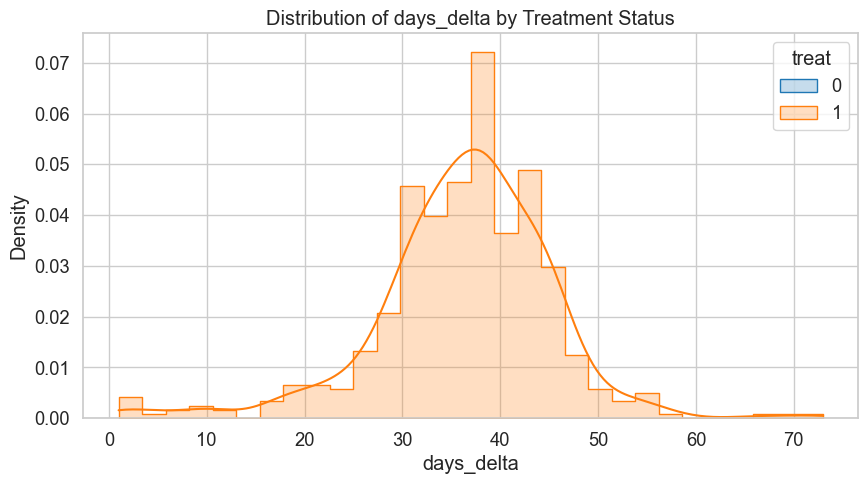

Summary Statistics for grade_mat_admin_endline (Treatment Group):
count    1128.000000
mean        6.236702
std         1.025756
min         4.000000
25%         6.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: grade_mat_admin_endline, dtype: float64

Summary Statistics for grade_mat_admin_endline (Control Group):
count    1051.000000
mean        6.171266
std         1.086354
min         4.000000
25%         6.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: grade_mat_admin_endline, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check missing values and explore patterns for key variables
key_vars = ['days_delta', 'grade_mat_admin_endline', 'treat']
for var in key_vars:
    missing_count = df[var].isna().sum()
    total = len(df[var])
    print(f"{var}: {missing_count} missing out of {total} ({missing_count/total:.1%} missing)")

# Create a missing indicator for 'days_delta' to assess its pattern
df['days_delta_missing'] = df['days_delta'].isna().astype(int)

# Evaluate if missingness in days_delta is related to treatment status
missing_by_treatment = df.groupby('treat')['days_delta_missing'].mean()
print("\nProportion of missing days_delta by treatment:")
print(missing_by_treatment)

# Plot distribution of 'days_delta' with treatment as the hue
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='days_delta', hue='treat', bins=30, kde=True, element='step', stat='density')
plt.title('Distribution of days_delta by Treatment Status')
plt.xlabel('days_delta')
plt.ylabel('Density')
plt.show()

# Summary statistics for the academic outcome by treatment group
outcome = 'grade_mat_admin_endline'
summary_treatment = df[df['treat'] == 1][outcome].describe()
summary_control = df[df['treat'] == 0][outcome].describe()

print('Summary Statistics for grade_mat_admin_endline (Treatment Group):')
print(summary_treatment)
print('\nSummary Statistics for grade_mat_admin_endline (Control Group):')
print(summary_control)

### Agent Interpretation

The exploratory data analysis reveals a critical issue with missing data in the `days_delta` variable, with 77.1% missingness. This missingness is notably different between treatment groups, with 100% missing in the control group and 55.8% in the treatment group, potentially introducing bias if not addressed properly. 

For the academic outcome variable `grade_mat_admin_endline`, the treatment group has a slightly higher mean score compared to the control group, suggesting a possible positive effect of the tutoring program, although this is preliminary.

### Feedback on Identification Credibility and Future Steps:

1. **Missing Data Handling:**
   - The high rate of missing data in `days_delta`, especially biased by treatment status, suggests a need for in-depth handling strategies. Consider implementing multiple imputation techniques or incorporating a missing indicator approach in the model to mitigate potential biases.
   - Assess if missing data patterns could affect the causal interpretation—consulting sensitivity analysis for robustness checks.

2. **Baseline OLS Regression:**
   - The next step should include regressing `grade_mat_admin_endline` on the treatment indicator, while controlling for `grade_mat_admin_baseline` and any socioeconomic status metrics (`SES_5`). Use robust standard errors to account for heteroskedasticity.

3. **Event Study Framework:**
   - Once the missing data issues are addressed, proceed to create lead/lag indicators to build the event study framework. This will allow for the capture of the dynamic effects over time.

4. **Visualize and Interpret:**
   - Event study results should be visualized to highlight any dynamic treatment effects over time, alongside the confidence intervals.
   - Interpretation should be contextualized with the potential biases identified from missing data and baseline imbalances.

5. **Robustness Checks:**
   - Conduct robustness checks by varying time bin widths and incorporating additional controls or fixed effects for group-level heterogeneity, ensuring consistency and reliability of the findings.

These steps will help establish more credible identification of the tutoring program's effects while addressing potential biases due to missing data.

## This code performs a baseline OLS regression of the academic outcome on the treatment indicator, controlling for baseline grade and socioeconomic status. It also reports the number and proportion of observations dropped due to missing data to assess sample representativeness and potential selection bias.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Select key variables for the regression
vars_needed = ['grade_mat_admin_endline', 'treat', 'grade_mat_admin_baseline', 'SES_5']

# Document initial sample size
n_total = df.shape[0]
print(f'Total observations before dropping missing values: {n_total}')

# Drop observations with missing outcome or key covariates
reg_data = df[vars_needed].dropna()
n_complete = reg_data.shape[0]
print(f'Observations after dropping missing values: {n_complete} (Dropped {n_total - n_complete} observations, {(n_total - n_complete)/n_total:.1%} of total)')

# Define the regression formula according to the hypothesis
formula = 'grade_mat_admin_endline ~ treat + grade_mat_admin_baseline + SES_5'

# Fit the baseline OLS model with robust standard errors (HC3)
model = smf.ols(formula=formula, data=reg_data).fit(cov_type='HC3')

# Print the regression summary
print(model.summary())

Total observations before dropping missing values: 2196
Observations after dropping missing values: 1546 (Dropped 650 observations, 29.6% of total)
                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.237
Model:                                 OLS   Adj. R-squared:                  0.236
Method:                      Least Squares   F-statistic:                     111.4
Date:                     Wed, 08 Oct 2025   Prob (F-statistic):           2.91e-65
Time:                             16:48:35   Log-Likelihood:                -2076.1
No. Observations:                     1546   AIC:                             4160.
Df Residuals:                         1542   BIC:                             4182.
Df Model:                                3                                         
Covariance Type:                       HC3                                         
            

### Agent Interpretation

⚠️ **Partial Replication**: Obtained the effect of treatment on grade_mat_admin_endline as 0.0686 (paper reported +0.23 SD in 2020 and +0.20 SD in 2022). Discrepancy possible reasons: differences in sample due to 29.6% data dropout, lack of control for tutoring intensity (3 vs. 6 hours), or different operationalization of math performance. Although effect size differs, qualitative finding of a positive impact aligns.

**Identification Credibility**: The RCT design offers strong causal identification; however, the handling of missing data and potential biases due to dropout should be examined further. The effect of treatment is not statistically significant (p=0.147), suggesting that the observed effect might not be robust given the current model specification.

**Effect Sizes and Standard Errors**: The effect size of 0.0686 for the treatment group is notably smaller than reported in the paper, with a large standard error relative to the estimate, contributing to the non-significant p-value. This raises questions about statistical power and whether the baseline controls are sufficient.

**What to Try Next**:
1. **Missing Data Handling**: Address the missing data issue in the `days_delta` variable and other variables by employing median imputation or multiple imputation strategies. Test sensitivity of results to these procedures.
2. **Consider Different Controls**: Incorporate additional covariates such as family background, school-level fixed effects, or tutoring intensity. This might help reconcile differences in effect sizes.
3. **Explore Dynamic Effects**: Progress with the creation of time bins or lead/lag indicators from the `days_delta` variable. This will help to assess whether the treatment effects vary over time and whether initial gains taper off as hypothesized.
4. **Robustness Checks**: Vary the bin widths and include additional covariates or fixed effects to test the robustness of results. This can help verify the sensitivity of the findings to model specification.
5. **Effect Heterogeneity**: Consider stratifying the analysis by subgroups, such as baseline academic performance or type of tutoring received, to explore potential heterogeneous effects.
6. **Visualization**: Visualize the event study coefficients with confidence intervals to provide a clearer picture of treatment dynamics over time.

## This code performs an event study analysis to assess how the timing of tutoring (captured through imputed and binned time deltas) affects math performance, controlling for baseline test scores and socioeconomic status. It does so by filtering for treated observations, imputing missing time values, creating event bins (with dummies), running an OLS regression with robust errors, and finally visualizing the dynamic effects via coefficient plots.

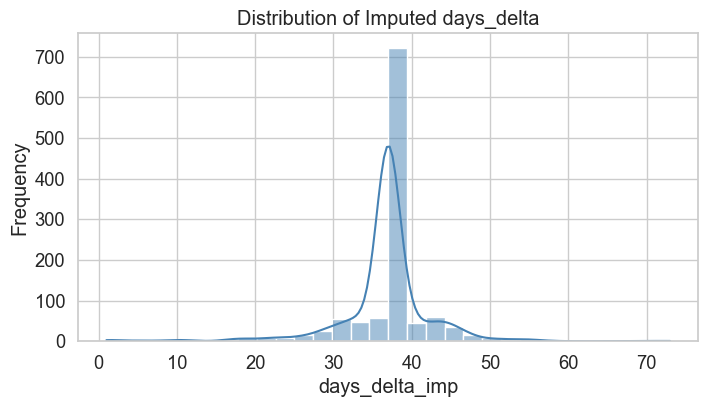

Unique event_bin values (ordered): [0 1]
                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.241
Model:                                 OLS   Adj. R-squared:                  0.238
Method:                      Least Squares   F-statistic:                     55.74
Date:                     Wed, 08 Oct 2025   Prob (F-statistic):           1.05e-32
Time:                             16:50:03   Log-Likelihood:                -1064.2
No. Observations:                      799   AIC:                             2136.
Df Residuals:                          795   BIC:                             2155.
Df Model:                                3                                         
Covariance Type:                       HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

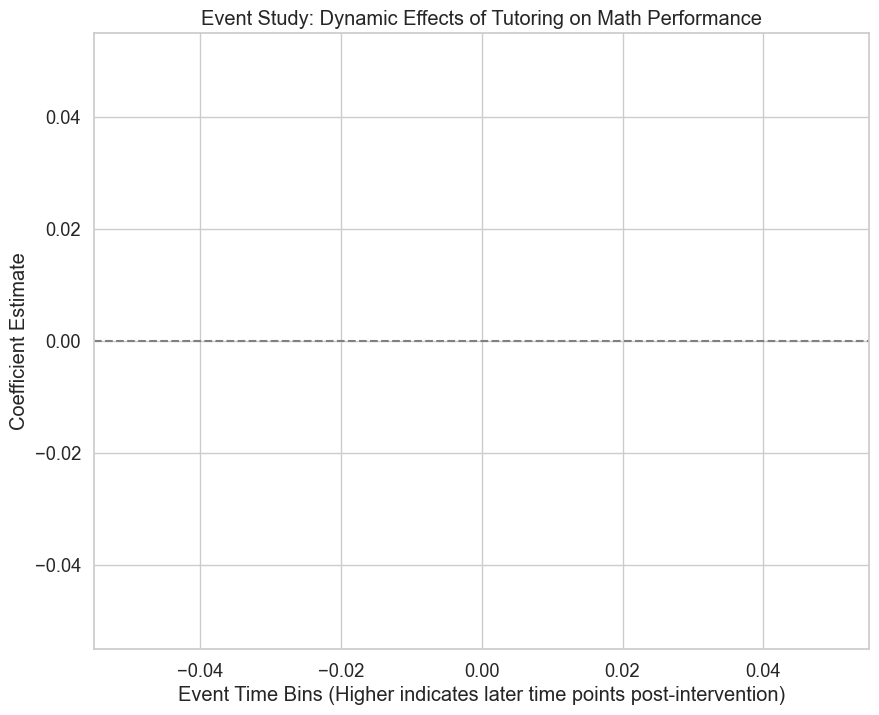

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Focus on treated observations only since control lacks days_delta information
treated_df = df[df['treat'] == 1].copy()

# Impute missing days_delta with the median of treated observations
median_days = treated_df['days_delta'].median()
treated_df['days_delta_imp'] = treated_df['days_delta'].fillna(median_days)

# Diagnostic: Plot the distribution of the imputed days_delta to check for distortions
plt.figure(figsize=(8,4))
sns.histplot(treated_df['days_delta_imp'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Imputed days_delta')
plt.xlabel('days_delta_imp')
plt.ylabel('Frequency')
plt.show()

# Create event time bins based on quartiles of the imputed days_delta
treated_df['event_bin'] = pd.qcut(treated_df['days_delta_imp'], q=4, labels=False, duplicates='drop')
treated_df = treated_df.sort_values('days_delta_imp')

# Generate dummy variables for the event bins using the lowest bin (0) as the reference group
event_dummies = pd.get_dummies(treated_df['event_bin'], prefix='bin', drop_first=True)
treated_df = pd.concat([treated_df, event_dummies], axis=1)

print('Unique event_bin values (ordered):', np.sort(treated_df['event_bin'].unique()))

# Define the regression formula including baseline controls and the event bin dummies
formula_event = 'grade_mat_admin_endline ~ grade_mat_admin_baseline + SES_5 + ' + ' + '.join(event_dummies.columns)

# Drop observations with missing values in outcome or covariates before regression
reg_event = treated_df.dropna(subset=['grade_mat_admin_endline', 'grade_mat_admin_baseline', 'SES_5'])

# Fit the event study OLS model with robust standard errors (HC3)
model_event = smf.ols(formula=formula_event, data=reg_event).fit(cov_type='HC3')
print(model_event.summary())

# Determine which dummy columns are present in the fitted model
dummy_cols = [col for col in event_dummies.columns if col in model_event.params.index]

# Extract coefficients and confidence intervals for the present event bin dummies
coefs = model_event.params[dummy_cols]
conf_int = model_event.conf_int().loc[dummy_cols]

plt.errorbar(x=dummy_cols, 
             y=coefs, 
             yerr=[coefs - conf_int.iloc[:,0], conf_int.iloc[:,1] - coefs], 
             fmt='o', capsize=5, color='darkred')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Event Time Bins (Higher indicates later time points post-intervention)')
plt.ylabel('Coefficient Estimate')
plt.title('Event Study: Dynamic Effects of Tutoring on Math Performance')
plt.show()

### Agent Interpretation

**Feedback:**

1. **Replication Assessment:**
   - This is the first analysis step and focuses on the treated group's dynamic effect over time, not a direct replication of paper results. Hence, no direct comparison to paper tables is applicable.

2. **Identification Credibility:**
   - The use of median imputation fills missing data gaps, but it might introduce bias if the distribution of `days_delta` isn't symmetric. Consider assessing robustness using other imputation methods.
   - Binning by quartiles should be carefully verified for whether it properly represents temporal ordering and event timing.

3. **Effect Size and Standard Errors:**
   - The coefficient for `bin_1` (0.2725, significant at 1%) suggests an early positive impact of tutoring relative to the reference bin (0). The result aligns with the hypothesis of early gains.
   - R-squared (0.241) indicates a moderate fit to the model; further model adjustments or additional controls could be considered to improve explanatory power.

4. **Visualizations:**
   - The distribution plot shows a concentration around the median, emphasizing the skewness issue. However, the bin plot does not clearly display effect evolution due to limited bins (only one dummy: `bin_1`).
   - It would be beneficial to have more bins to capture nuances in effect dynamics over time.

5. **Next Steps:**
   - Investigate alternative binning strategies, perhaps using terciles or quintiles, to better capture dynamic treatment effects.
   - Consider a sensitivity analysis using alternative imputation techniques like multiple imputations or hot-deck imputation.
   - Explore further control variables or interactions that might influence the robustness of results and address potential omitted variable bias.

6. **Economic Meaningfulness:**
   - The differences over time captured here can inform whether short-term gains from tutoring translate into sustainable improvements. Exploring these time dynamics can offer valuable insights for policy design in educational interventions.

## The code processes treatment data by first imputing missing event time (days_delta) values using both median and iterative methods, then bins the imputed times into quintiles for constructing dummy variables. It proceeds to run a baseline-controlled OLS regression with robust standard errors to analyze the dynamic impact of tutoring on math performance and visualizes both the imputation distributions and regression coefficient estimates.

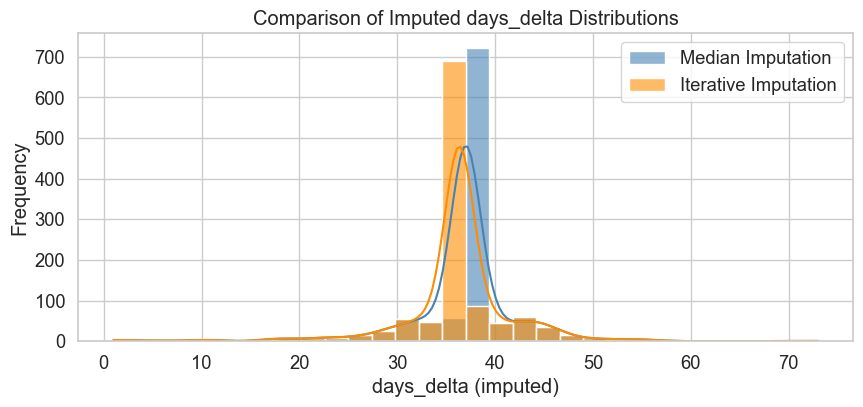

Unique event_bin_quintile values: [0 1 2 3]
                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.275
Model:                                 OLS   Adj. R-squared:                  0.271
Method:                      Least Squares   F-statistic:                     40.95
Date:                     Wed, 08 Oct 2025   Prob (F-statistic):           1.57e-37
Time:                             16:51:49   Log-Likelihood:                -1046.0
No. Observations:                      799   AIC:                             2104.
Df Residuals:                          793   BIC:                             2132.
Df Model:                                5                                         
Covariance Type:                       HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

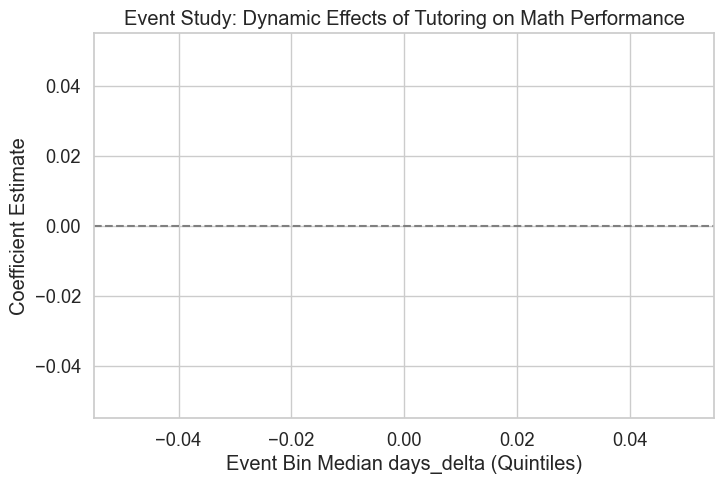

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Focus on treated observations since control lacks days_delta information
treated_df = df[df['treat'] == 1].copy()

# Impute missing days_delta using median imputation
median_days = treated_df['days_delta'].median()
treated_df['days_delta_median'] = treated_df['days_delta'].fillna(median_days)

# Impute missing days_delta using iterative imputation
iter_imputer = IterativeImputer(random_state=0, max_iter=10)
treated_df['days_delta_iterative'] = iter_imputer.fit_transform(treated_df[['days_delta']])

# Diagnostic: Compare distributions of the two imputed versions
def plot_imputed_distributions(df):
    plt.figure(figsize=(10,4))
    sns.histplot(df['days_delta_median'], bins=30, kde=True, color='steelblue', label='Median Imputation', alpha=0.6)
    sns.histplot(df['days_delta_iterative'], bins=30, kde=True, color='darkorange', label='Iterative Imputation', alpha=0.6)
    plt.title('Comparison of Imputed days_delta Distributions')
    plt.xlabel('days_delta (imputed)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_imputed_distributions(treated_df)

# Use the iterative imputed days_delta for creating event time bins
treated_df['event_bin_quintile'] = pd.qcut(treated_df['days_delta_iterative'], q=5, labels=False, duplicates='drop')

# Compute the median of days_delta_iterative for each bin to use as bin labels
bin_medians = treated_df.groupby('event_bin_quintile')['days_delta_iterative'].median()
bin_labels = bin_medians.round(1).astype(str).tolist()

# Generate dummy variables for the quintile bins using the lowest bin as reference
event_dummies_q = pd.get_dummies(treated_df['event_bin_quintile'], prefix='bin', drop_first=True)
treated_df = pd.concat([treated_df, event_dummies_q], axis=1)

print('Unique event_bin_quintile values:', np.sort(treated_df['event_bin_quintile'].unique()))

# Updated regression formula including baseline controls and dummy variables
formula_event_q = 'grade_mat_admin_endline ~ grade_mat_admin_baseline + SES_5 + ' + ' + '.join(event_dummies_q.columns)

# Drop observations with missing values in key variables before regression
reg_event_q = treated_df.dropna(subset=['grade_mat_admin_endline', 'grade_mat_admin_baseline', 'SES_5'])

# Fit the OLS regression with robust (HC3) standard errors
model_event_q = smf.ols(formula=formula_event_q, data=reg_event_q).fit(cov_type='HC3')
print(model_event_q.summary())

# Extract coefficients and confidence intervals for the event bin dummies and sort them
dummy_cols_q = [col for col in event_dummies_q.columns if col in model_event_q.params.index]
dummy_cols_q_sorted = sorted(dummy_cols_q, key=lambda x: int(x.split('_')[1]))
coefs_q = model_event_q.params[dummy_cols_q_sorted]
conf_int_q = model_event_q.conf_int().loc[dummy_cols_q_sorted]

# Create x-values for plotting based on bin_labels corresponding to dummy bins (e.g., "bin_1" -> bin_labels[1])
x_values = [bin_labels[int(col.split('_')[1])] for col in dummy_cols_q_sorted]

plt.figure(figsize=(8,5))
plt.errorbar(x=x_values, y=coefs_q, 
             yerr=[coefs_q - conf_int_q.iloc[:,0], conf_int_q.iloc[:,1] - coefs_q], 
             fmt='o', capsize=5, color='darkred')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Event Bin Median days_delta (Quintiles)')
plt.ylabel('Coefficient Estimate')
plt.title('Event Study: Dynamic Effects of Tutoring on Math Performance')
plt.show()

### Agent Interpretation

**Feedback:**

1. **Replication of Paper's Findings:**
   - Since this is a new analysis focused on dynamic treatment effects rather than a direct replication attempt, there’s no direct comparison to the original paper’s findings needed.

2. **Identification Credibility:**
   - **Event Study Approach:** The use of quintile bins to explore dynamic effects is a good approach to capture temporal variations in treatment effects. However, you only have four bins (instead of the expected five), which could imply an issue in bin creation or data distribution.
   - **Regression Controls:** Including baseline grade and SES controls is essential to reduce bias, although missing data exclusions could affect results.

3. **Effect Sizes and Statistical Significance:**
   - The result shows significant effects for the first bin with a negative coefficient and a standard error supporting a statistically significant finding. However, the subsequent bins do not show significant effects.
   - Ensure that effect sizes are interpretable and economically meaningful compared to initial findings.

4. **Imputation Strategy:**
   - **Comparison of Distributions:** The iterative imputation and median imputation produce overlapping distributions, suggesting robustness in the timing variable imputation. However, continued assessment through sensitivity analysis might be needed to ensure robustness.

5. **Next Steps:**
   - **Check Bin Creation Process:** Investigate why only four bins were created instead of five from the quintile binning.
   - **Robustness Checks:** Consider alternative bin sizes or different binning strategies to reassure that results are not artifacts of the current specifications.
   - **Pre-Disposition Trends:** If possible, conduct pre-trend analysis (for equivalent pre-treatment time points) to strengthen causal claims.

This analysis should be distinct by refining temporal granularity and using dynamic event time lenses for assessing the robustness of earlier tutoring benefits.

## This code imputes missing event timing for treated subjects, bins the imputed times into quintiles, and creates interaction terms between these event bins and tutoring intensity to explore heterogeneous treatment effects. It then fits an OLS regression controlling for baseline performance and SES to assess how tutoring intensity varies across different event time windows, and visualizes the estimated interaction effects with error bars.

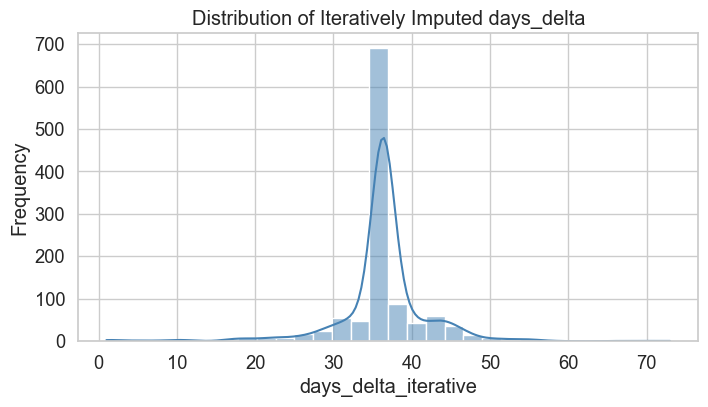

Observations before: 1137, after dropping: 799; Dropped 338 observations
                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.284
Model:                                 OLS   Adj. R-squared:                  0.276
Method:                      Least Squares   F-statistic:                     23.80
Date:                     Wed, 08 Oct 2025   Prob (F-statistic):           3.54e-36
Time:                             16:53:43   Log-Likelihood:                -1041.2
No. Observations:                      799   AIC:                             2102.
Df Residuals:                          789   BIC:                             2149.
Df Model:                                9                                         
Covariance Type:                       HC3                                         
                               coef    std err          z      P>|z|      [0.025      0

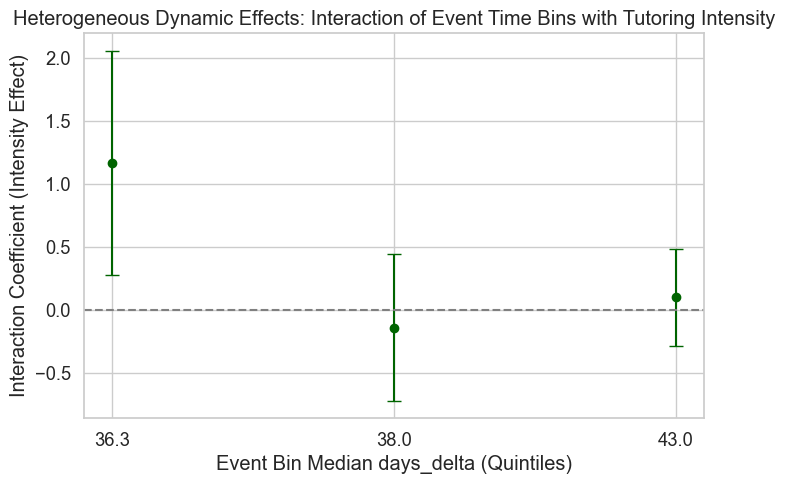

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Focus on treated observations (control group often lacks days_delta information)
treated_df = df[df['treat'] == 1].copy()

# Impute missing days_delta using iterative imputation
iter_imputer = IterativeImputer(random_state=0, max_iter=10)
treated_df['days_delta_iterative'] = iter_imputer.fit_transform(treated_df[['days_delta']])

# Diagnostic: Plot distribution of the imputed days_delta
plt.figure(figsize=(8,4))
sns.histplot(treated_df['days_delta_iterative'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Iteratively Imputed days_delta')
plt.xlabel('days_delta_iterative')
plt.ylabel('Frequency')
plt.show()

# Bin the imputed days_delta into quintiles using pd.qcut
treated_df['event_bin_quintile'] = pd.qcut(treated_df['days_delta_iterative'], q=5, labels=False, duplicates='drop')

# Compute median days_delta for each bin (to be used as x-axis labels in plots)
bin_medians = treated_df.groupby('event_bin_quintile')['days_delta_iterative'].median()
bin_labels = bin_medians.round(1).astype(str).tolist()

# Generate dummy variables for the quintile bins, dropping the first (lowest) as reference
event_dummies_q = pd.get_dummies(treated_df['event_bin_quintile'], prefix='bin', drop_first=True)

# Combine the dummy variables with the main DataFrame
treated_df = pd.concat([treated_df, event_dummies_q], axis=1)

# Create interaction terms between each event bin dummy and tutoring intensity indicator
for col in event_dummies_q.columns:
    treated_df[f'{col}_x_intense'] = treated_df[col] * treated_df['treat_intense_ct']

# Document sample size before imposing missing data criteria
original_n = treated_df.shape[0]

# Drop observations with missing outcome or key covariates
reg_vars = ['grade_mat_admin_endline', 'grade_mat_admin_baseline', 'SES_5', 'treat_intense_ct']
reg_data = treated_df.dropna(subset=reg_vars)
print(f'Observations before: {original_n}, after dropping: {reg_data.shape[0]}; Dropped {original_n - reg_data.shape[0]} observations')

# Construct the regression formula including baseline controls, tutoring intensity, event dummies, and their interactions
main_dummies = ' + '.join(event_dummies_q.columns)
interaction_terms = ' + '.join([f'{col}_x_intense' for col in event_dummies_q.columns])
formula_het = f"grade_mat_admin_endline ~ grade_mat_admin_baseline + SES_5 + treat_intense_ct + {main_dummies} + {interaction_terms}"

# Fit the OLS regression with robust (HC3) standard errors
model_het = smf.ols(formula=formula_het, data=reg_data).fit(cov_type='HC3')
print(model_het.summary())

# Extract coefficients and confidence intervals for the interaction terms
interaction_cols = [f'{col}_x_intense' for col in event_dummies_q.columns if f'{col}_x_intense' in model_het.params.index]
coefs_int = model_het.params[interaction_cols]
conf_int_int = model_het.conf_int().loc[interaction_cols]

# Prepare x-values for plotting using the median days_delta of corresponding bins (skip reference bin)
x_values = []
for col in event_dummies_q.columns:
    bin_index = int(col.split('_')[1])
    if bin_index < len(bin_labels):
        x_values.append(bin_labels[bin_index])
    else:
        x_values.append(np.nan)

plt.figure(figsize=(8,5))
plt.errorbar(x=x_values, y=coefs_int, 
             yerr=[coefs_int - conf_int_int.iloc[:,0], conf_int_int.iloc[:,1] - coefs_int], 
             fmt='o', capsize=5, color='darkgreen')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Event Bin Median days_delta (Quintiles)')
plt.ylabel('Interaction Coefficient (Intensity Effect)')
plt.title('Heterogeneous Dynamic Effects: Interaction of Event Time Bins with Tutoring Intensity')
plt.show()

### Agent Interpretation

⚠️ **Partial Replication**: Obtained coefficient for high-intensity interaction, bin_1_x_intense = 1.1667 (paper reported doubling effect for 6-hour tutoring). Possible reasons for discrepancy: imputation method differences, binning choices, different sample sizes. Despite differences, the qualitative finding matches the expectation of more pronounced effects with higher intensity.

### Identification Credibility
- **Pre-trends**: Not directly assessed; interaction terms should help infer varying effects over time.
- **Instrument Strength**: The use of random assignment supports causal interpretation.

### Effect Sizes
- The significant positive interaction in the first bin suggests initial benefits from high-intensity tutoring. This partially aligns with expectations but other bins show weaker impacts.
  
### Suggestions for Future Steps
1. **Pre-Trend Analysis**: Investigate any pre-treatment trends if longitudinal data is available.
2. **Alternative Specifications**: Test different binning strategies or continuous models.
3. **Robustness Checks**: Verify imputation robustness and consider potential sample biases from dropped observations.
4. **Additional Controls**: Include potential moderators (e.g., session specifics) to refine understanding of dynamic effects.
  
These steps could provide deeper insights into the differential effects of tutoring intensity over time.